In [1]:
# imports
from ema_workbench.analysis import parcoords
import pandas as pd
import numpy as np
from ema_workbench import load_results
import seaborn as sns
import os
from model.enums import BeliefUpdate
from dmdu.utils_dmdu import get_lever_names, get_outcome_names
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
from dmdu.exploration.utils import parcoords_levers, parcoords_outcomes

sns.set(rc={'figure.figsize': (7, 5)})

# Assign each unique model a color
model_names = [x.name for x in list(BeliefUpdate)]
model_colors = {}
colors = ["darkorange", "blue", "limegreen"]
alpha = 0.15


for _, (model, color) in enumerate(zip(model_names, colors)):
    # w/ color palette: zip(model_names, sns.color_palette("colorblind"))
    model_colors[model] = (color, alpha)


# Overall Plan:
1. load data
2. process data (rescales lever values & avg over replications)        -> saved 'experiments.csv' & 'outcomes.csv' for each bufn
3. parallel axis plots of levers & outcomes (colored by policy (reevaluated Pareto-optimal policy))


### 1. Loading the data (results), avg over replications, save into .csv
(can just avg bc replications to make sure that sensitivity to stochasticity is not an issue wrt reproducibility)

In [2]:
# Params  # TODO: make a function 'load_my_csv(nfe, bufn, filename, seed=None)'
# bufns = list(BeliefUpdate)
#
# for bufn in bufns:
#
#     # Loading the results
#     path = os.path.join(
#         os.getcwd(),
#         "data",
#         "reevaluation",
#         f"results_{bufn.name}",
#     )
#     experiments, outcomes = load_results(path)
#
#     # Experiments: Rescale lever values (*10 -> (0-10 -> 0-100, 0-5 -> 0-50))
#     lever_names = get_lever_names()
#     for col_name in experiments.columns:
#         if col_name in lever_names:
#             experiments[col_name] *= 10
#
#     # Outcomes: Avg over replications (for each scenario)
#     # TODO: for each scenario: get subset for one scenario, only then avg as below
#
#     metrics_series = {}
#     # for metric in outcomes.keys():  # attempt
#     for metric in get_outcome_names():
#         indiv_values = outcomes[metric]
#         avgs_per_exp = np.mean(indiv_values, axis=1)
#         metric_ser = pd.Series(avgs_per_exp)
#         metrics_series[metric] = metric_ser
#
#     avgs_outcomes = pd.DataFrame(metrics_series)
#
#     # Save into .csv  (dict -> df -> .csv)
#     path = os.path.join(
#         os.getcwd(),
#         "data",
#         "reevaluation",
#         f"outcomes_{bufn.name}.csv"
#     )
#     avgs_outcomes.to_csv(path)
#
#     path = os.path.join(
#         os.getcwd(),
#         "data",
#         "reevaluation",
#         f"experiments_{bufn.name}.csv"
#     )
#     experiments.to_csv(path)


### 3. parallel axis plots of levers & outcomes
(to inspect Pareto-optimal policies)


#### a) subset experiments (all 26k policies -> only pareto-optimal policies


#### b) Load data files

In [3]:
# Load data files
experiments_dict = {}
outcomes_dict = {}
bufns = list(BeliefUpdate)

for bufn in bufns:
    # define paths
    exp_path = os.path.join(os.getcwd(), "data", "reevaluation", f"experiments_{bufn.name}.csv")
    out_path = os.path.join(os.getcwd(), "data", "reevaluation", f"outcomes_{bufn.name}.csv")
    # load data
    experiments = pd.read_csv(exp_path)
    outcomes = pd.read_csv(out_path)
    outcomes = outcomes[get_outcome_names()]  # without 'Unnamed: 0'

    # save data
    experiments_dict[bufn.name] = experiments
    outcomes_dict[bufn.name] = outcomes


In [4]:
# Load data files
other_outcomes_dict = {}
bufns = list(BeliefUpdate)

for bufn in bufns:
    # define paths
    exp_path = os.path.join(os.getcwd(), "data", "paretosort", "output", f"experiments_{bufn.name}.csv")
    out_path = os.path.join(os.getcwd(), "data", "paretosort", "output", f"outcomes_{bufn.name}.csv")
    # load data
    outcomes = pd.read_csv(out_path)
    outcomes = outcomes[get_outcome_names()]  # without 'Unnamed: 0'

    # save data
    other_outcomes_dict[bufn.name] = outcomes

#### c) Create parallel axis plots

##### Policies (i.e., Levers)

In [5]:
# # Policies (i.e., Levers)
#
# def parcoords_levers(exp_dict, bufn, model_colors=None):
#     """Plots a parallel axis plot for the passed belief update function (bufn)"""
#
#     # Get limits
#     exp_path = os.path.join(os.getcwd(), "data", "paretosort", "input", f"experiments_{bufn.name}.csv")
#     all_exp = pd.read_csv(exp_path)
#     only_levers = all_exp[get_lever_names()]
#     exp_limits = parcoords.get_limits(only_levers)
#
#     # Parallel axis plot
#     axes = parcoords.ParallelAxes(exp_limits)
#     data = exp_dict[bufn.name][get_lever_names()]
#     if model_colors:
#         color = model_colors[bufn.name]
#         axes.plot(data, color=color)
#     else:
#         axes.plot(data)



##### DEFFUANT

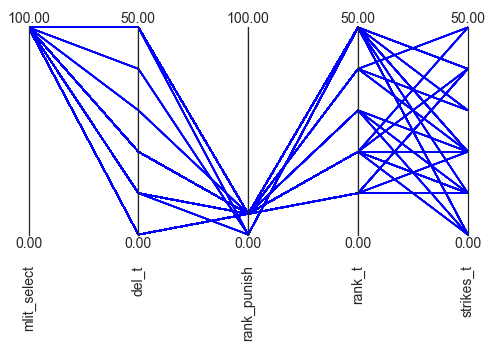

In [5]:
bufn = BeliefUpdate.DEFFUANT
parcoords_levers(experiments_dict, bufn, model_colors)

##### SAMPLE

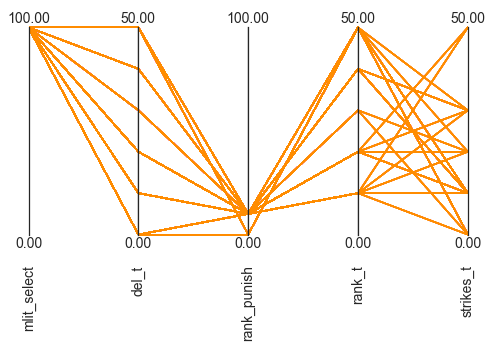

In [6]:
bufn = BeliefUpdate.SAMPLE
parcoords_levers(experiments_dict, bufn, model_colors)

##### SIT

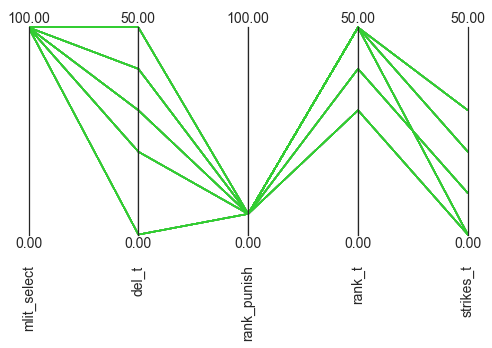

In [7]:
bufn = BeliefUpdate.SIT
parcoords_levers(experiments_dict, bufn, model_colors)

##### Combined
(not easy to see. bc Few possible values -> many overlaps)
# TODO: Would be good to have e.g., densitiy visible over range of lever dimension

In [8]:
concat_exp = pd.concat(experiments_dict.values())

# Get limits from input (-> not only Pareto-optimal policies, but all)
exp_path = os.path.join(os.getcwd(), "data", "paretosort", "input", f"experiments_DEFFUANT.csv")
# doesn't matter which bufn loaded above, all evaluated the same policies
all_exp = pd.read_csv(exp_path)
only_levers = all_exp[get_lever_names()]
exp_limits = parcoords.get_limits(only_levers)

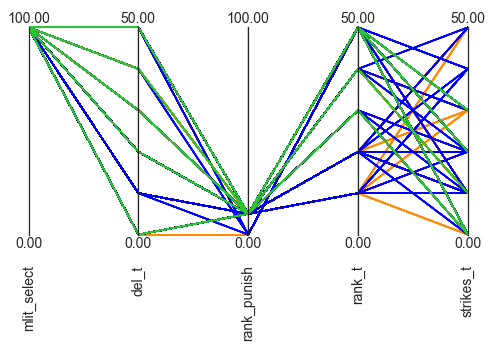

In [9]:
axes = parcoords.ParallelAxes(exp_limits)

for model_name, data in experiments_dict.items():
    color, alpha = model_colors[model_name]

    # subset data
    lever_data = data[get_lever_names()]
    axes.plot(lever_data, color=color, alpha=alpha)


##### Performance (i.e., Outcomes)

In [10]:
# Find limits over all outcomes



In [11]:
# def parcoords_outcomes(out_dict, bufn, model_colors=None):
#
#     # Get limits
#     concat_out = pd.concat(out_dict.values())
#     out_limits = parcoords.get_limits(concat_out)
#
#     axes = parcoords.ParallelAxes(out_limits)
#
#     minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
#     for metric in minimize:
#         axes.invert_axis(metric)
#
#     if model_colors:
#         color = model_colors[bufn.name]
#         axes.plot(data, color=color)
#     else:
#         axes.plot(data)




In [6]:
# Outcome plots need to be a bit bigger
sns.set(rc={'figure.figsize': (7, 9)})

##### DEFFUANT

In [7]:
bufn_list = [BeliefUpdate.DEFFUANT]

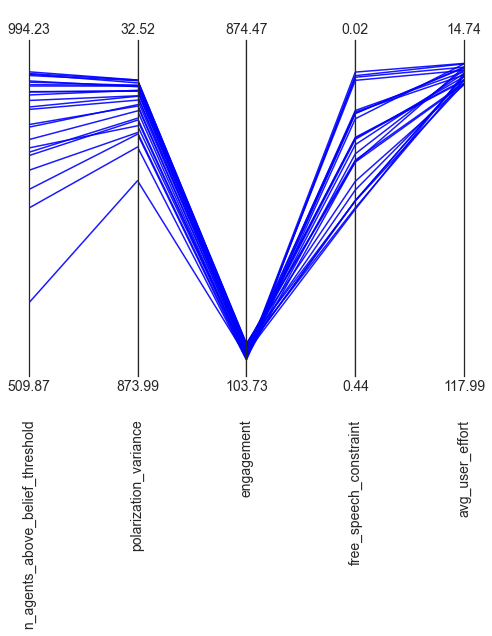

In [8]:
parcoords_outcomes(other_outcomes_dict, bufn_list, model_colors, other_out_dict_for_limits=outcomes_dict)

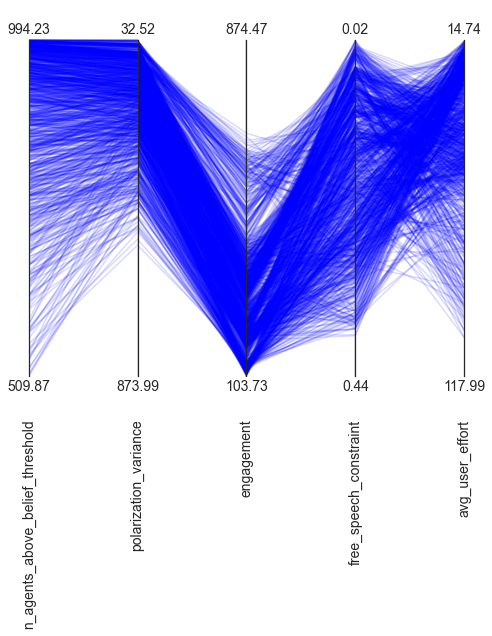

In [9]:
parcoords_outcomes(outcomes_dict, bufn_list, model_colors, other_out_dict_for_limits=other_outcomes_dict)

##### SAMPLE

In [10]:
bufn_list = [BeliefUpdate.SAMPLE]

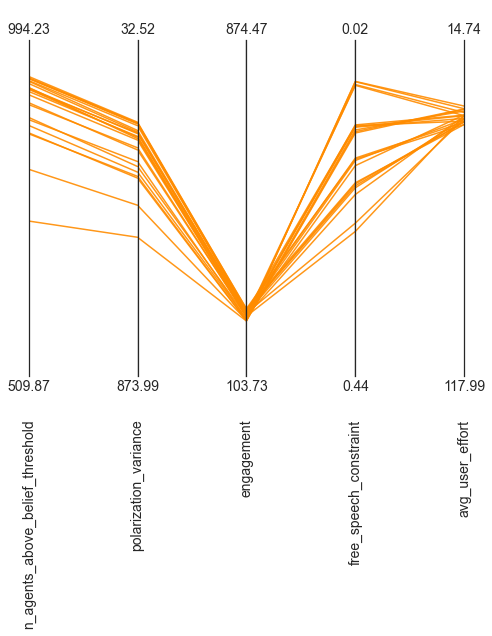

In [11]:
parcoords_outcomes(other_outcomes_dict, bufn_list, model_colors, other_out_dict_for_limits=outcomes_dict)

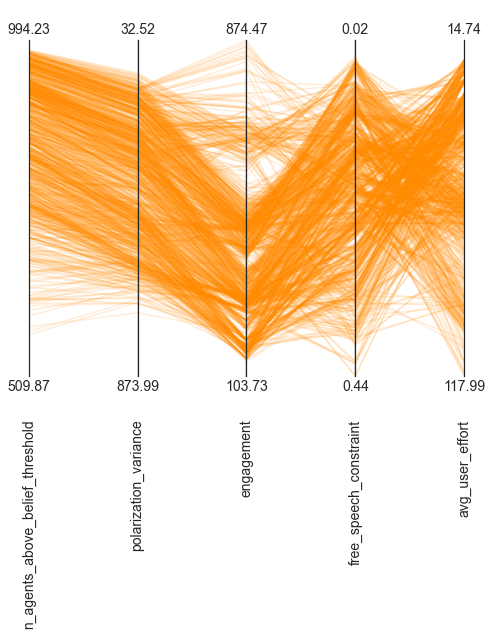

In [12]:
parcoords_outcomes(outcomes_dict, bufn_list, model_colors, other_out_dict_for_limits=other_outcomes_dict)

##### SIT

In [13]:
bufn_list = [BeliefUpdate.SIT]


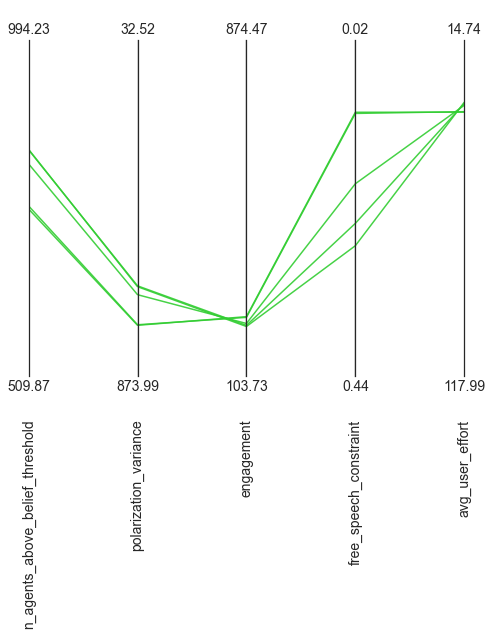

In [14]:
parcoords_outcomes(other_outcomes_dict, bufn_list, model_colors, other_out_dict_for_limits=outcomes_dict)


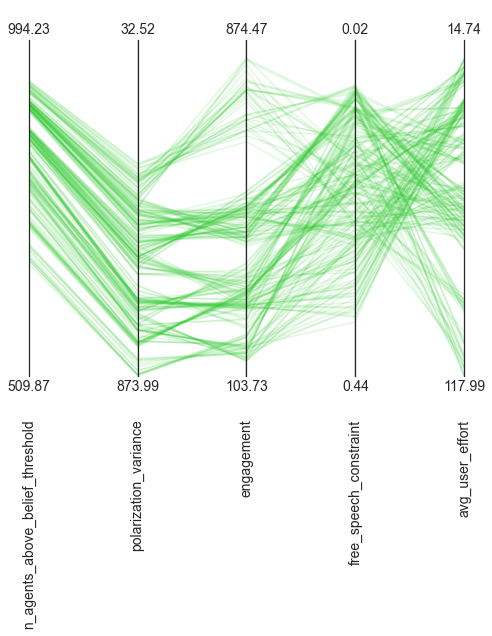

In [15]:
parcoords_outcomes(outcomes_dict, bufn_list, model_colors, other_out_dict_for_limits=other_outcomes_dict)

##### Combined


In [16]:
bufn_list = list(BeliefUpdate)

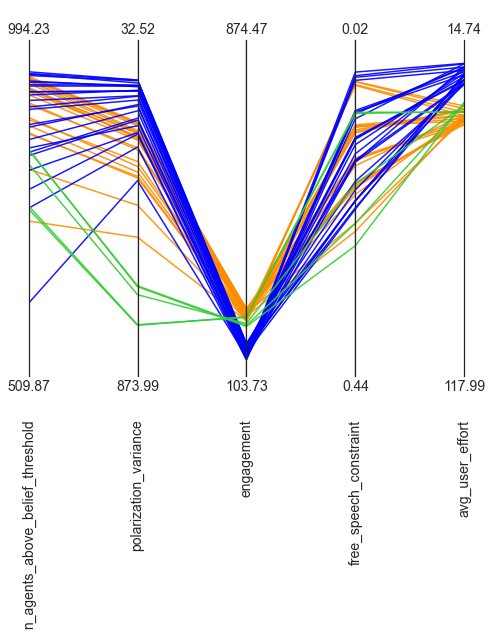

In [17]:
parcoords_outcomes(other_outcomes_dict, bufn_list, model_colors, other_out_dict_for_limits=outcomes_dict)

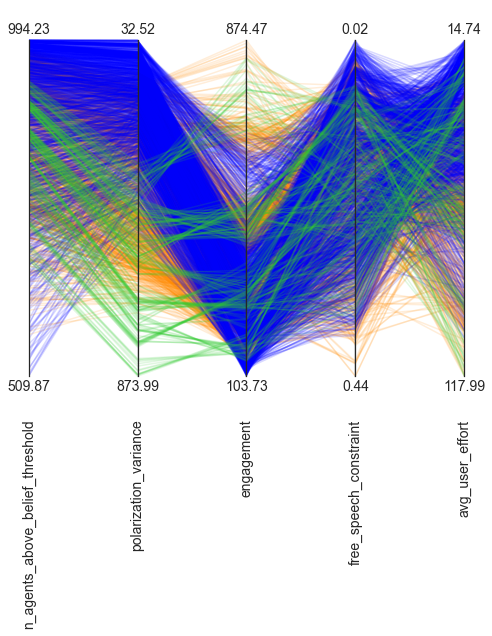

In [17]:
parcoords_outcomes(outcomes_dict, bufn_list, model_colors, other_out_dict_for_limits=other_outcomes_dict)

In [18]:

# Get limits
# concat_out = pd.concat(outcomes_dict.values())
# out_limits = parcoords.get_limits(concat_out)
#
# axes = parcoords.ParallelAxes(out_limits)
#
# minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
# for metric in minimize:
#     axes.invert_axis(metric)
#
#
# for bufn in list(BeliefUpdate):
#     bufn = bufn.name
#
#     color, alpha = model_colors[bufn]
#     axes.plot(outcomes_dict[bufn], color=color, alpha=alpha)